```
streamlit run your_script.py [-- script args]
```

In [2]:
%%writefile offozaynapp/config.py

sheet_url = 'https://docs.google.com/spreadsheets/d/10qMx2LXQkjOMX_lB2LHWVi8OzI_-HaN0/edit?usp=sharing&ouid=111709418728007906825&rtpof=true&sd=true'
sheet_url = 'https://docs.google.com/spreadsheets/d/1-0B0CN3y-K0CYoPCHpsh2TKpDP3N1rIm/edit?usp=sharing&ouid=111709418728007906825&rtpof=true&sd=true'
nodes = "https://drive.google.com/file/d/1-0cpXZHUDGToKKlP_niCbjwBfQK3urSz/view?usp=sharing"
edges = "https://drive.google.com/file/d/14BW0OXkbN7BgwCTZ2YpTATAL5PBRRGRs/view?usp=sharing"
lat_lon_url = 'https://drive.google.com/file/d/10l-06L2waxvG6pKbCwuX1wtPtrPjgPO4/view?usp=sharing'
lat_lon_url = 'https://drive.google.com/file/d/13B1B_6tt_-mgt2kD719ZF_ElvPn34OKp/view?usp=sharing'



Overwriting offozaynapp/config.py


In [ ]:
%%writefile __init__.py




In [4]:
%%writefile offozaynapp/tools.py

import config
import streamlit as st
import graphviz as graphviz
import pandas as pd
import networkx as nx
from PIL import Image
import platform
import plotly.figure_factory as ff
import numpy as np

# Taken with modification from
# https://newbedev.com/pandas-how-to-read-csv-file-from-google-drive-public"""
get_url = lambda u: 'https://drive.google.com/uc?export=download&id=' + u.split('/')[-2]
    

def check_platform():
    pl = platform.platform()
    if pl.startswith('macOS'):
        return 'local'
    return 'remote'

def is_local():
    return check_platform()=='local'
    
    
@st.cache(suppress_st_warning=True, show_spinner=False)
def load_data(url, nrows):
    data = pd.read_csv(get_url(url), nrows=nrows) 
    return data

@st.cache(suppress_st_warning=True, show_spinner=False)
def load_nodes():
    if is_local():
        return pd.read_csv('./data/nodes_single.csv', low_memory=False) 
    else:
        return pd.read_csv(get_url(config.nodes), low_memory=False)
    
@st.cache(suppress_st_warning=True, show_spinner=False)
def load_edges():
    if is_local():
        return pd.read_csv('./data/edges_all_single.csv', low_memory=False) 
    else:
        return pd.read_csv(get_url(config.edges), low_memory=False)

@st.cache
def load_lat_lon(show_spinner=False):
    if is_local():
        return pd.read_csv("~/Google Drive/My Drive/GA/capstone/data/clean/nodes_edges/nodes_lat_lon.csv") 
#         return pd.read_csv('./data/nodes_lat_lon.csv') 
    else:
        return pd.read_csv(get_url(config.lat_lon_url))


@st.cache(suppress_st_warning=True, show_spinner=False)
def read_xlsx(sheet, nrows=10000):
    if is_local():
        return pd.read_excel('./data/specific_edges_single.xlsx', sheet_name=sheet, nrows=nrows)
    else:
        return pd.read_excel(get_url(config.sheet_url), sheet_name=sheet, nrows=nrows)


def create_digraph_new(df, count=10):   
    """
    https://discuss.streamlit.io/t/support-for-networkx-pyvis-and-folium/190/2
    """
    final_count = min(df.shape[0], count)
    df.sort_values(by='weight', ascending=False, inplace=True)
    G = nx.DiGraph()
    G.add_weighted_edges_from([tuple(x) for x in df.head(final_count).values])
    dot = nx.nx_pydot.to_pydot(G)
    st.graphviz_chart(dot.to_string(), use_container_width=True)
    
def show_image(name, caption):
    image = Image.open(f'images/{name}')
    st.image(image, caption=caption)

    

Overwriting offozaynapp/tools.py


In [122]:
%%writefile offozaynapp/main.py

import tools
import plotly_tools
import streamlit as st
import pandas as pd
import numpy as np
import platform
import maptools

st.set_page_config(page_title="Offshore Leaks Exploration")


st.title('Offshore Leaks')

#st.write(platform.platform())

select_list = ['', 'jurisdiction', 'countries', 'country_codes', 'continents', 'company_type', 'jurisdiction_description', 'table']
select_dict = {k.replace('_', ' ').title(): k for k in select_list}


select_key = st.sidebar.selectbox(
    "Which field would you like to explore?",
    tuple(select_dict.keys())
)

select_value = select_dict[select_key]

if select_value:
    st.write(select_value)
    
    if tools.is_local():
        if select_value == 'countries':
            tools.show_image('top_25_countries__address__intermediary__officer__entity.png', 'Countries')



    weight_data = tools.read_xlsx(select_value)
    st.write(f'Total {weight_data.shape[0]} edges')

    st.subheader('Edges - Weighted')
    st.write(weight_data.head())

#     weight_data = weight_data[weight_data['weight']>1]
    
    if st.checkbox('Show raw data'):
        st.subheader(f'{select_key} Source')
        hist_values = weight_data[f'{select_value}_source'].value_counts().sort_values(ascending=False)
        n_columns = st.slider('How many columns?', 0, hist_values.shape[0], min(10, hist_values.shape[0]))
        st.bar_chart(hist_values.head(n_columns))
        st.write(hist_values)

    
    n_edges = st.slider('How many edges?', 0, min(weight_data.shape[0], 100), min(10, weight_data.shape[0]))
    tools.create_digraph_new(weight_data, n_edges)
    
if st.checkbox('Show Latitude & Longitude data'):
    lat_lon_data = tools.load_lat_lon()
    st.subheader('Raw data')
    st.write(lat_lon_data.head())
    st.map(lat_lon_data, zoom=1)
    
# if tools.is_local():  
#     #tools.sample_plotly()
    
if st.checkbox('Show plotly'):
    plotly_tools.test_plotly()

#     plotly_tools.test_plotly2()

if st.checkbox('Show Map plotly'):
    maptools.map_plotly()

Overwriting offozaynapp/main.py


In [121]:
%%writefile offozaynapp/plotly_tools.py

import tools
import networkx as nx
import streamlit as st
import plotly.express as px
import plotly.graph_objects as go

@st.cache(suppress_st_warning=True, show_spinner=False)
def get_graph():
    data_load_state = st.text('Loading data ... ')
    nodes = tools.load_nodes()
    edges = tools.load_edges()
    edges = edges.sample(500)
    data_load_state.text('Loading data ... done!')
    
    col_edges_conv = {'START_ID': 'source', 
                  'END_ID': 'target',
                  'link': 'Type',
                  'active_days': 'Active Days'
                  }
    col_nodes_conv = {'countries': 'Country', 
                    'continents': 'Region',
                    'jurisdiction': 'Jurisdiction', 
                    'service_provider': 'Service Provider',
                    'company_type': 'Company Type'}

    edges_cols = ['START_ID', 'END_ID', 'active_days', 'link']
    nodes_cols = ['node_id', 'countries', 'continents','jurisdiction', 'service_provider', 'company_type', 'location']
    linkData = edges[edges_cols].rename(columns = col_edges_conv)
    nodeData = nodes[nodes_cols].rename(columns = col_nodes_conv )
    data_load_state = st.text('Making graph ...')
    G = nx.from_pandas_edgelist(linkData, 'source', 'target', True, nx.DiGraph())
    nx.set_node_attributes(G, nodeData.set_index('node_id').to_dict('index'))
    data_load_state.text('Making Graph ... done!')
    return G


@st.cache(suppress_st_warning=True, show_spinner=False)
def test_plotly():

    G = get_graph()

    field = 'location'
    
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = eval(G.nodes[edge[0]][field])
        x1, y1 = eval(G.nodes[edge[1]][field])
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        



    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = eval(G.nodes[node][field])
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))
    
    node_adjacencies = []
    node_text = []
    for node, adjacencies in enumerate(G.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append('# of connections: '+str(len(adjacencies[1])))

    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text



    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Title',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
#                 margin=dict(b=20,l=5,r=5,t=40),
#                 annotations=[ dict(
#                     text="",
#                     showarrow=False,
#                     xref="paper", yref="paper",
#                     x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

    st.plotly_chart(fig)
    
def test_plotly2():


    G = nx.random_geometric_graph(200, 0.125)

#     data_load_state = st.text('Loading data...')
#     nodes = tools.load_nodes()
#     edges = tools.load_edges()
#     data_load_state.text('Loading data...done!')
    
    
#     st.write(nodes.head(2))
#     st.write(edges.head(2))
    
#     G = get_graph(nodes, edges)

    field = 'pos'
    
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]][field]
        x1, y1 = G.nodes[edge[1]][field]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = G.nodes[node][field]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))
    
    node_adjacencies = []
    node_text = []
    for node, adjacencies in enumerate(G.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append('# of connections: '+str(len(adjacencies[1])))

    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text



    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Title',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
#                 margin=dict(b=20,l=5,r=5,t=40),
#                 annotations=[ dict(
#                     text="",
#                     showarrow=False,
#                     xref="paper", yref="paper",
#                     x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

    st.plotly_chart(fig)
    
def sample_plotly():


    # Add histogram data
    x1 = np.random.randn(200) - 2
    x2 = np.random.randn(200)
    x3 = np.random.randn(200) + 2

    # Group data together
    hist_data = [x1, x2, x3]

    group_labels = ['Group 1', 'Group 2', 'Group 3']

    # Create distplot with custom bin_size
    fig = ff.create_distplot(
             hist_data, group_labels, bin_size=[.1, .25, .5])

    # Plot!
    st.plotly_chart(fig, use_container_width=True)

Overwriting offozaynapp/plotly_tools.py


In [120]:
%%writefile offozaynapp/maptools.py
# https://plotly.com/python/lines-on-maps/

import streamlit as st

import plotly.graph_objects as go
import pandas as pd
import tools

@st.cache(suppress_st_warning=True, show_spinner=False)
def map_plotly():

    data_load_state = st.text('Loading data ... ')
    nodes = tools.load_nodes()
    edges = tools.load_edges()
    edges = edges.sample(500)
    st.write(edges.head(2))
    data_load_state.text('Loading data ... done!')


    fig = go.Figure()

    fig.add_trace(go.Scattergeo(
        locationmode = 'country names',
        lon = nodes['longitude'].tolist(),
        lat = nodes['latitude'].tolist(),
        hoverinfo = 'text',
        text = nodes['countries'].tolist(),
        mode = 'markers',
        marker = dict(
            size = 2,
            color = 'rgb(255, 0, 0)',
            line = dict(
                width = 3,
                color = 'rgba(68, 68, 68, 0)'
            )
        )))

    flight_paths = []
    for i in range(edges.shape[0]):
        fig.add_trace(
            go.Scattergeo(
                locationmode = 'country names',
                lon = [edges.iloc[i]['longitude_source'], edges.iloc[i]['longitude_target']],
                lat = [edges.iloc[i]['latitude_source'], edges.iloc[i]['latitude_target']],
                mode = 'lines',
                line = dict(width = 1,color = 'blue'),
#                 opacity = float(df_flight_paths['cnt'][i]) / float(df_flight_paths['cnt'].max()),
            )
        )

    fig.update_layout(
        title_text = 'Title',
        showlegend = False,
        geo = dict(
            scope = 'world',
            projection_type = 'equirectangular',
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )

#     fig.show()
    st.plotly_chart(fig, use_container_width=True)

def map_plotly2():

    df_airports = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_us_airport_traffic.csv')
    df_airports.head()

    df_flight_paths = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_aa_flight_paths.csv')
    df_flight_paths.head()

    fig = go.Figure()

    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = df_airports['long'],
        lat = df_airports['lat'],
        hoverinfo = 'text',
        text = df_airports['airport'],
        mode = 'markers',
        marker = dict(
            size = 2,
            color = 'rgb(255, 0, 0)',
            line = dict(
                width = 3,
                color = 'rgba(68, 68, 68, 0)'
            )
        )))

    flight_paths = []
    for i in range(len(df_flight_paths)):
        fig.add_trace(
            go.Scattergeo(
                locationmode = 'USA-states',
                lon = [df_flight_paths['start_lon'][i], df_flight_paths['end_lon'][i]],
                lat = [df_flight_paths['start_lat'][i], df_flight_paths['end_lat'][i]],
                mode = 'lines',
                line = dict(width = 1,color = 'red'),
                opacity = float(df_flight_paths['cnt'][i]) / float(df_flight_paths['cnt'].max()),
            )
        )

    fig.update_layout(
        title_text = 'Feb. 2011 American Airline flight paths<br>(Hover for airport names)',
        showlegend = False,
        geo = dict(
            scope = 'north america',
            projection_type = 'azimuthal equal area',
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )

    fig.show()
    st.plotly_chart(fig, use_container_width=True)

Overwriting offozaynapp/maptools.py


In [19]:
%%writefile offozaynapp/requirements.txt

graphviz
pydot
openpyxl
networkx
plotly
scipy

Overwriting offozaynapp/requirements.txt


In [ ]:
!pip install graphivz

In [ ]:
import pandas as pd


orig_url = 'https://docs.google.com/spreadsheets/d/10qMx2LXQkjOMX_lB2LHWVi8OzI_-HaN0/edit?usp=sharing&ouid=111709418728007906825&rtpof=true&sd=true'
orig_url = 'https://docs.google.com/spreadsheets/d/1-0B0CN3y-K0CYoPCHpsh2TKpDP3N1rIm/edit?usp=sharing&ouid=111709418728007906825&rtpof=true&sd=true'
file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id


xls = pd.ExcelFile(dwn_url)
df1 = pd.read_excel(xls, 'jurisdiction')


In [ ]:
df1

In [1]:
import graphviz

In [58]:
#!conda install -c anaconda graphviz -y
#!conda install -c anaconda pydot -y
#!conda install -c anaconda openpyxl -y

In [10]:
ls ../data/clean/graphs

company_type.edgelist*             jurisdiction.edgelist*
continents.edgelist*               jurisdiction_description.edgelist*
countries.edgelist*                node_id.edgelist*
country_codes.edgelist*            table.edgelist*


In [18]:
import networkx as nx

url = 'https://drive.google.com/file/d/10eXidO511doY2M7dLQMZE00lGSVu_Vez/view?usp=sharing'
get_url = lambda u: 'https://drive.google.com/uc?export=download&id=' + u.split('/')[-2]

df = pd.read_csv(get_url(url))

In [19]:
import networkx as nx
G = nx.DiGraph()
G.add_weighted_edges_from([tuple(x) for x in df.values])

In [20]:
G

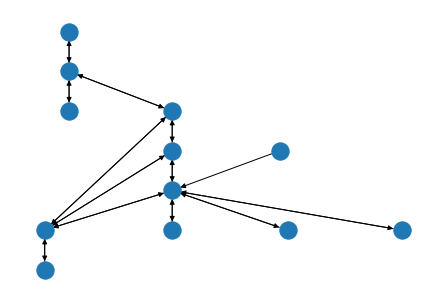

In [32]:
pos = nx.nx_pydot.graphviz_layout(G)
pos = nx.nx_pydot.graphviz_layout(G, prog="dot")
nx.draw(G, pos)